## Import Modules

In [1]:
import requests
import json
from io import StringIO
import os
import shapely
import pandas as pd
import matplotlib.pyplot as plt

# Install these!
import descartes
import geopandas
import contextily as ctx

In [2]:
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
outdir = "../../docs/results/latest/geo"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
NO_DATA_CHAR = "NA"
GEO_ATTR = "Province"
CRS="epsg:4326"
WEB_MERCATOR_CRS = "epsg:3857"

### Geo Config

In [69]:
# Order: bottom-left, bottom-right, top-right, top-left (sw, se, ne, nw)

region_poly = {
    "Caucasus" : {"wsen": [35.0000, 30.0009, 60.0000, 50.0000]},
    #Caucasus" : {"wsen": [40.058841, 40.202162, -75.042164, -74.924594]},
    "Europe" : {"wsen" : [-10, 30, 35, 70]},
    "Asia" : {"wsen" : [60, 0, 140, 70]},
}

df_columns = ["Region","Lon", "Lat"]
region_df = pd.DataFrame(columns=df_columns)

for region in region_poly:
    wsen = region_poly[region]["wsen"]
    
    # add to dataframe
    df = pd.DataFrame([
         [region, wsen[0], wsen[1]],
         [region, wsen[2], wsen[1]],
         [region, wsen[2], wsen[3]],
         [region, wsen[0], wsen[3]],
         ],
         columns=df_columns
    )
    region_df = region_df.append(df, ignore_index = True)
    
    # Polygon should be: sw, se, ne, nw
    region_poly[region]["poly"] = shapely.geometry.Polygon([
        (wsen[0], wsen[1]), 
        (wsen[2], wsen[1]), 
        (wsen[2], wsen[3]), 
        (wsen[0], wsen[3]),
    ])
    region_poly[region]["geoseries"] = geopandas.GeoSeries(region_poly[region]["poly"])
    region_poly[region]["geoseries"].crs = CRS
    region_poly[region]["xlim"] = (wsen[0], wsen[2])
    region_poly[region]["ylim"] = (wsen[1], wsen[3])

region_gdf = geopandas.GeoDataFrame(
    region_df, 
    geometry=geopandas.points_from_xy(region_df.Lon, region_df.Lat))
region_gdf.set_crs(CRS, inplace=True)

,Region,Lon,Lat,geometry
0,Caucasus,35.0,30.0009,POINT (35.00000 30.00090)
1,Caucasus,60.0,30.0009,POINT (60.00000 30.00090)
2,Caucasus,60.0,50.0000,POINT (60.00000 50.00000)
3,Caucasus,35.0,50.0000,POINT (35.00000 50.00000)
4,Europe,-10.0,30.0000,POINT (-10.00000 30.00000)
5,Europe,35.0,30.0000,POINT (35.00000 30.00000)
6,Europe,35.0,70.0000,POINT (35.00000 70.00000)
7,Europe,-10.0,70.0000,POINT (-10.00000 70.00000)
8,Asia,60.0,0.0000,POINT (60.00000 0.00000)
9,Asia,140.0,0.0000,POINT (140.00000 0.00000)


In [70]:
region_gdf.to_crs(epsg=3857)

,Region,Lon,Lat,geometry
0,Caucasus,35.0,30.0009,POINT (3896182.178 3503665.531)
1,Caucasus,60.0,30.0009,POINT (6679169.448 3503665.531)
2,Caucasus,60.0,50.0000,POINT (6679169.448 6446275.841)
3,Caucasus,35.0,50.0000,POINT (3896182.178 6446275.841)
4,Europe,-10.0,30.0000,POINT (-1113194.908 3503549.844)
5,Europe,35.0,30.0000,POINT (3896182.178 3503549.844)
6,Europe,35.0,70.0000,POINT (3896182.178 11068715.659)
7,Europe,-10.0,70.0000,POINT (-1113194.908 11068715.659)
8,Asia,60.0,0.0000,POINT (6679169.448 0.000)
9,Asia,140.0,0.0000,POINT (15584728.711 0.000)


### Global Plot Config

In [4]:
dpi=400

DEF_COL_LIST = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

### Contextily Basemaps

In [88]:
# Change the geoseries crs
region_gdf.to_crs(epsg=3857, inplace=True)

0    POINT (3896182.178 3503665.531)
1    POINT (6679169.448 3503665.531)
2    POINT (6679169.448 6446275.841)
3    POINT (3896182.178 6446275.841)
Name: geometry, dtype: geometry
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


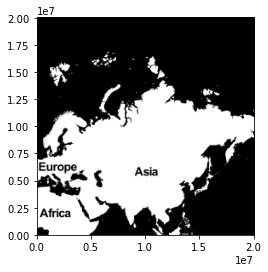

In [94]:
w = 3896182.178
s = 3503665.531
n = 6679169.448
e = 6446275.841

print(region_df[region_df["Region"] == "Caucasus"].geometry)

ctx_img, ctx_ext = ctx.bounds2img(
     w,
     s,
     e,
     n,
     ll=True,
     source=ctx.providers.Stamen.Toner,
     zoom=1,
     #crs=CRS,
    )
print(ctx_img)
plt.imshow(ctx_img, extent=ctx_ext)
# Reset the geoseries crs

'out_path = os.path.join(outdir, "liverpool.tif")  \n_ = ctx.bounds2raster(w, s, e, n,\n                     ll=True,\n                     path=out_path,\n                     source=ctx.providers.CartoDB.Positron\n                    )'

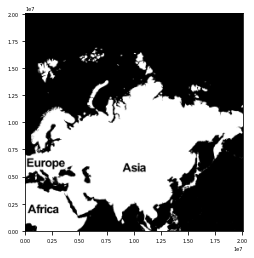

In [5]:
"""w, s, e, n = (-3.0816650390625,
              53.268087670237485,
             -2.7582550048828125,
              53.486002749115556)"""

w, s, e, n = (35,
              30,
             60,
              50)
ctx_img, ctx_ext = ctx.bounds2img(w,
                                     s,
                                     e,
                                     n,
                                     ll=True,
                                     source=ctx.providers.Stamen.Toner,
                                     zoom=1,
                                     #crs=CRS,
                                    )

plt.imshow(ctx_img, extent=ctx_ext)
"""out_path = os.path.join(outdir, "liverpool.tif")  
_ = ctx.bounds2raster(w, s, e, n,
                     ll=True,
                     path=out_path,
                     source=ctx.providers.CartoDB.Positron
                    )"""

---
## Import Dataframe

Read in as pandas dataframe

In [6]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

Convert to geopandas dataframe

In [7]:
# Remove NO DATA Cells
# RETHINK THIS WHEN INTERNAL NODES HAVE DATA!!
df = tree_df[tree_df[GEO_ATTR + "Lon"] != NO_DATA_CHAR]
geometry = [shapely.geometry.Point(xy) for xy in zip(df[GEO_ATTR + "Lon"], df[GEO_ATTR + "Lat"])]
df = df.drop([GEO_ATTR + "Lon", GEO_ATTR + "Lat"], axis=1)
#WGS84 = "epsg:4326"
gdf_points = geopandas.GeoDataFrame(df, crs=CRS, geometry=geometry)

## Import reference datasets

Import the world dataset from geopandas

In [8]:
gdf_points_count = {}

for geo in gdf_points[GEO_ATTR]:
    if geo not in gdf_points_count:
        gdf_points_count[geo] = 0
    gdf_points_count[geo] += 1

gdf_points_size = []

for geo in gdf_points[GEO_ATTR]:
    gdf_points_size.append(gdf_points_count[geo])

## Global

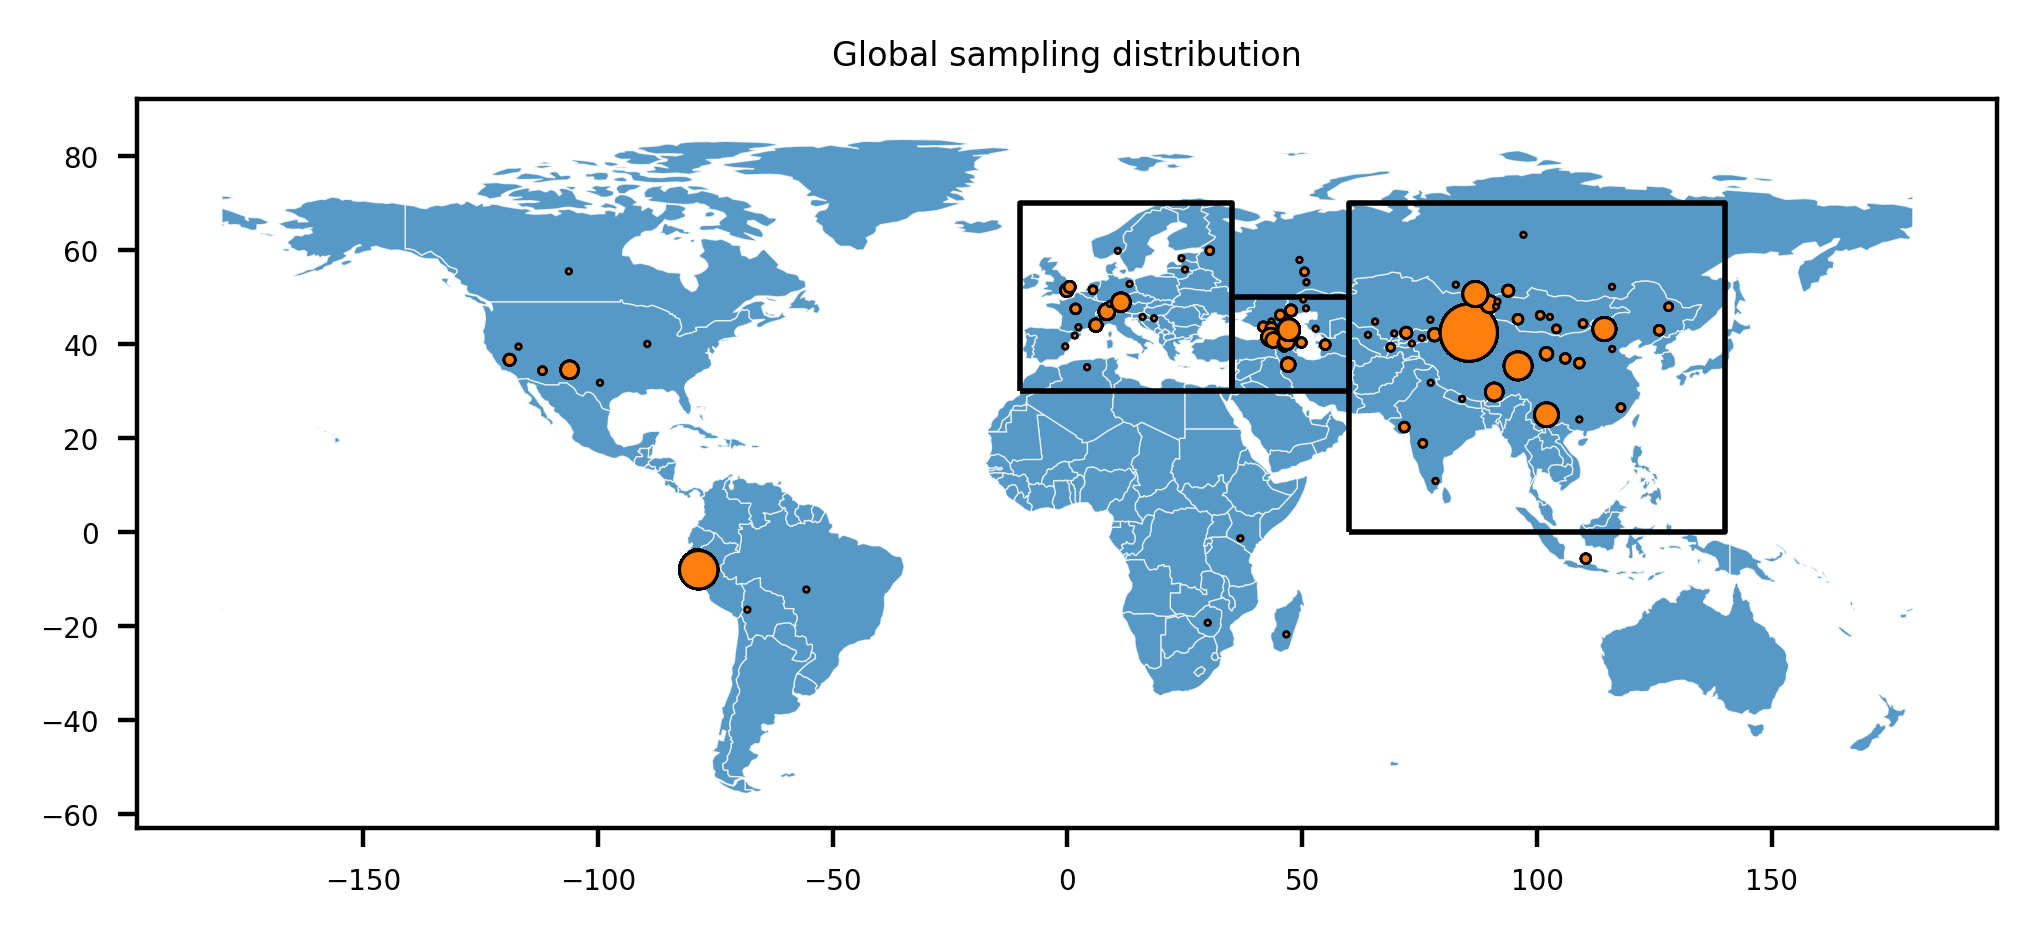

In [129]:
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax1 = plt.subplots(1, dpi=dpi)

# Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.75, 
                    color=DEF_COL_LIST[0],
                    edgecolor="white", 
                    linewidth=0.25)

# Points
gdf_points.plot(ax=ax1, 
                zorder=2, 
                markersize=gdf_points_size, 
                color=DEF_COL_LIST[1],
                edgecolor="black",
                linewidths=0.5,
                )

# Polygons
for region in region_poly:
    region_poly[region]["geoseries"].plot(color="none", edgecolor="black", ax=ax1)
#caucasus_geoseries.plot(color="none", edgecolor="black", ax=ax1)
#europe_geoseries.plot(color="none", edgecolor="black", ax=ax1)
#asia_geoseries.plot(color="none", edgecolor="black", ax=ax1)

ax1.set_ylim(-63,)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_title("Global sampling distribution")

#plt.axis('off')

# Save
out_path = os.path.join(outdir, "world_sample_distribution.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

## Caucasus

(35.0, 60.0, 30.0, 50.0)

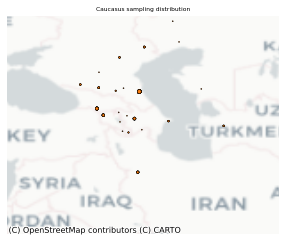

In [68]:
region_xlim = (35, 60)
region_ylim = [30, 50]

"""fig, ax1 = plt.subplots(1, 
                        dpi=dpi
                       )"""

ax1 = gdf_points.plot( 
                markersize=gdf_points_size, 
                color=DEF_COL_LIST[1],
                edgecolor="black",
                linewidths=0.5,
                )

ctx.add_basemap(
    ax1, 
    crs=gdf_points.crs.to_string(),
    #source=ctx.providers.Stamen.TonerLite,
    source=ctx.providers.CartoDB.Positron,
    zoom=3,
)

ax1.set_xlim(caucasus_xlim)
ax1.set_ylim(caucasus_ylim)
ax1.set_title("Caucasus sampling distribution")
plt.axis('off')

Text(0.5, 1.0, 'Caucasus sampling distribution')

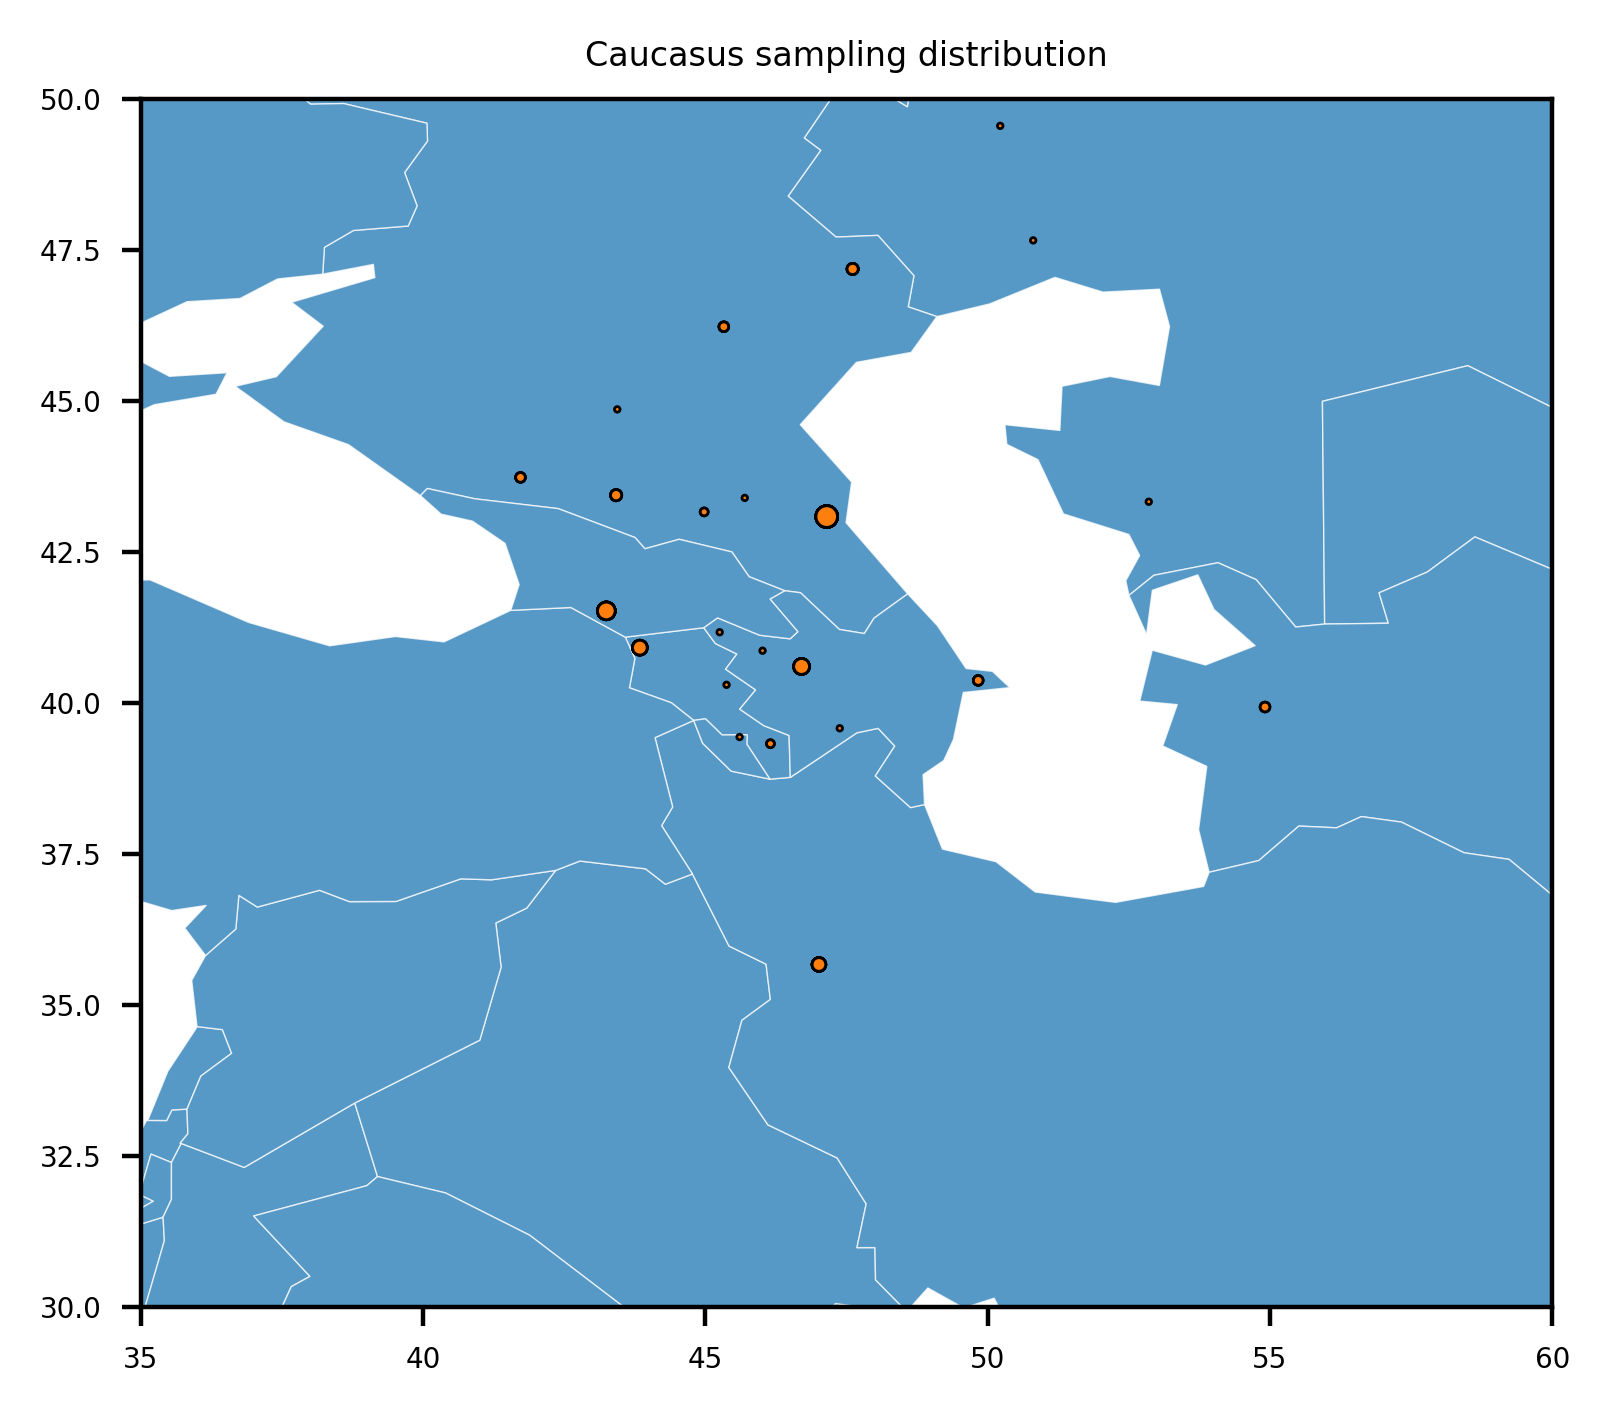

In [11]:
region_xlim = (35, 60)
region_ylim = [30, 50]

fig, ax1 = plt.subplots(1, 
                        dpi=dpi
                       )

# Size the points
gdf_points_count = {}
gdf_points[GEO_ATTR]

world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.75, 
                    color=DEF_COL_LIST[0],
                    edgecolor="white", 
                    linewidth=0.25)
gdf_points.plot(ax=ax1, 
                zorder=2, 
                markersize=gdf_points_size, 
                color=DEF_COL_LIST[1],
                edgecolor="black",
                linewidths=0.5,
                )

ax1.set_xlim(region_xlim)
ax1.set_ylim(region_ylim)
ax1.set_title("Caucasus sampling distribution")
#plt.axis('off')


In [12]:
"""db = gdf_points[gdf_points["Country"] == "Armenia"]
ax = gdf_points.plot(color="red", figsize=(9, 9))
ctx.add_basemap(
    ax, 
    crs=db.crs.to_string(),
    source=ctx.providers.Stamen.TerrainBackground,
)"""

'db = gdf_points[gdf_points["Country"] == "Armenia"]\nax = gdf_points.plot(color="red", figsize=(9, 9))\nctx.add_basemap(\n    ax, \n    crs=db.crs.to_string(),\n    source=ctx.providers.Stamen.TerrainBackground,\n)'

### Europe

---
## OLD

### Select specific countries

Armenia

### Plot with the world basemap

(30.0, 50.0)

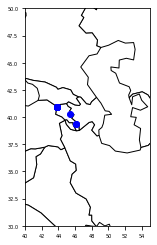

In [13]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = ["Armenia"]
data_point = gdf_points[gdf_points["Country"] == "Armenia"]

fig, ax1 = plt.subplots()
#world.plot(ax=ax, color='white', edgecolor='black')
#cities.plot(ax=ax, marker='o', color='red', markersize=5)
#cities.plot(color='k', ax=ax, zorder=2)
world.plot(ax=ax1, zorder=1, color="white", edgecolor="black");
data_point.plot(ax=ax1, color='blue', zorder=2)

ax1.set_xlim(40, 55)
ax1.set_ylim(30, 50)

(30.0, 50.0)

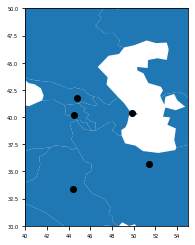

In [38]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

fig, ax = plt.subplots()
#world.plot(ax=ax, color='white', edgecolor='black')
#cities.plot(ax=ax, marker='o', color='red', markersize=5)
cities.plot(color='k', ax=ax, zorder=2)
world.plot(ax=ax, zorder=1);

ax.set_xlim(40, 55)
ax.set_ylim(30, 50)

## TEST

<AxesSubplot:>

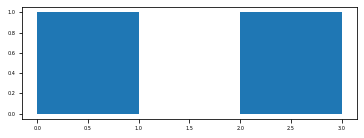

In [27]:
p1 = shapely.geometry.Polygon([(0, 0), (1, 0), (1, 1)])
p2 = shapely.geometry.Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = shapely.geometry.Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = geopandas.GeoSeries([p1, p2, p3])
g
g.plot()

<AxesSubplot:>

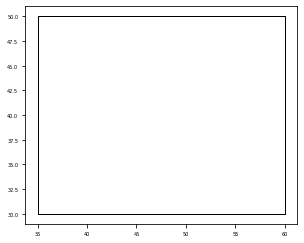

In [37]:
# Order: bottom-left, bottom-right, top-right, top-left (sw, se, ne, nw)
p1 = shapely.geometry.Polygon([(35, 30), (60, 30), (60, 50), (35, 50),])
#p1 = shapely.geometry.Polygon([(0, 0), (1, 0), (1, 1), (0,1)])
p2 = shapely.geometry.Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = shapely.geometry.Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
#g = geopandas.GeoSeries([p1, p2, p3])
g = geopandas.GeoSeries([p1])
g
g.plot(color="white", edgecolor="black")

Text(0.5, 1.0, 'Regions to highlight')

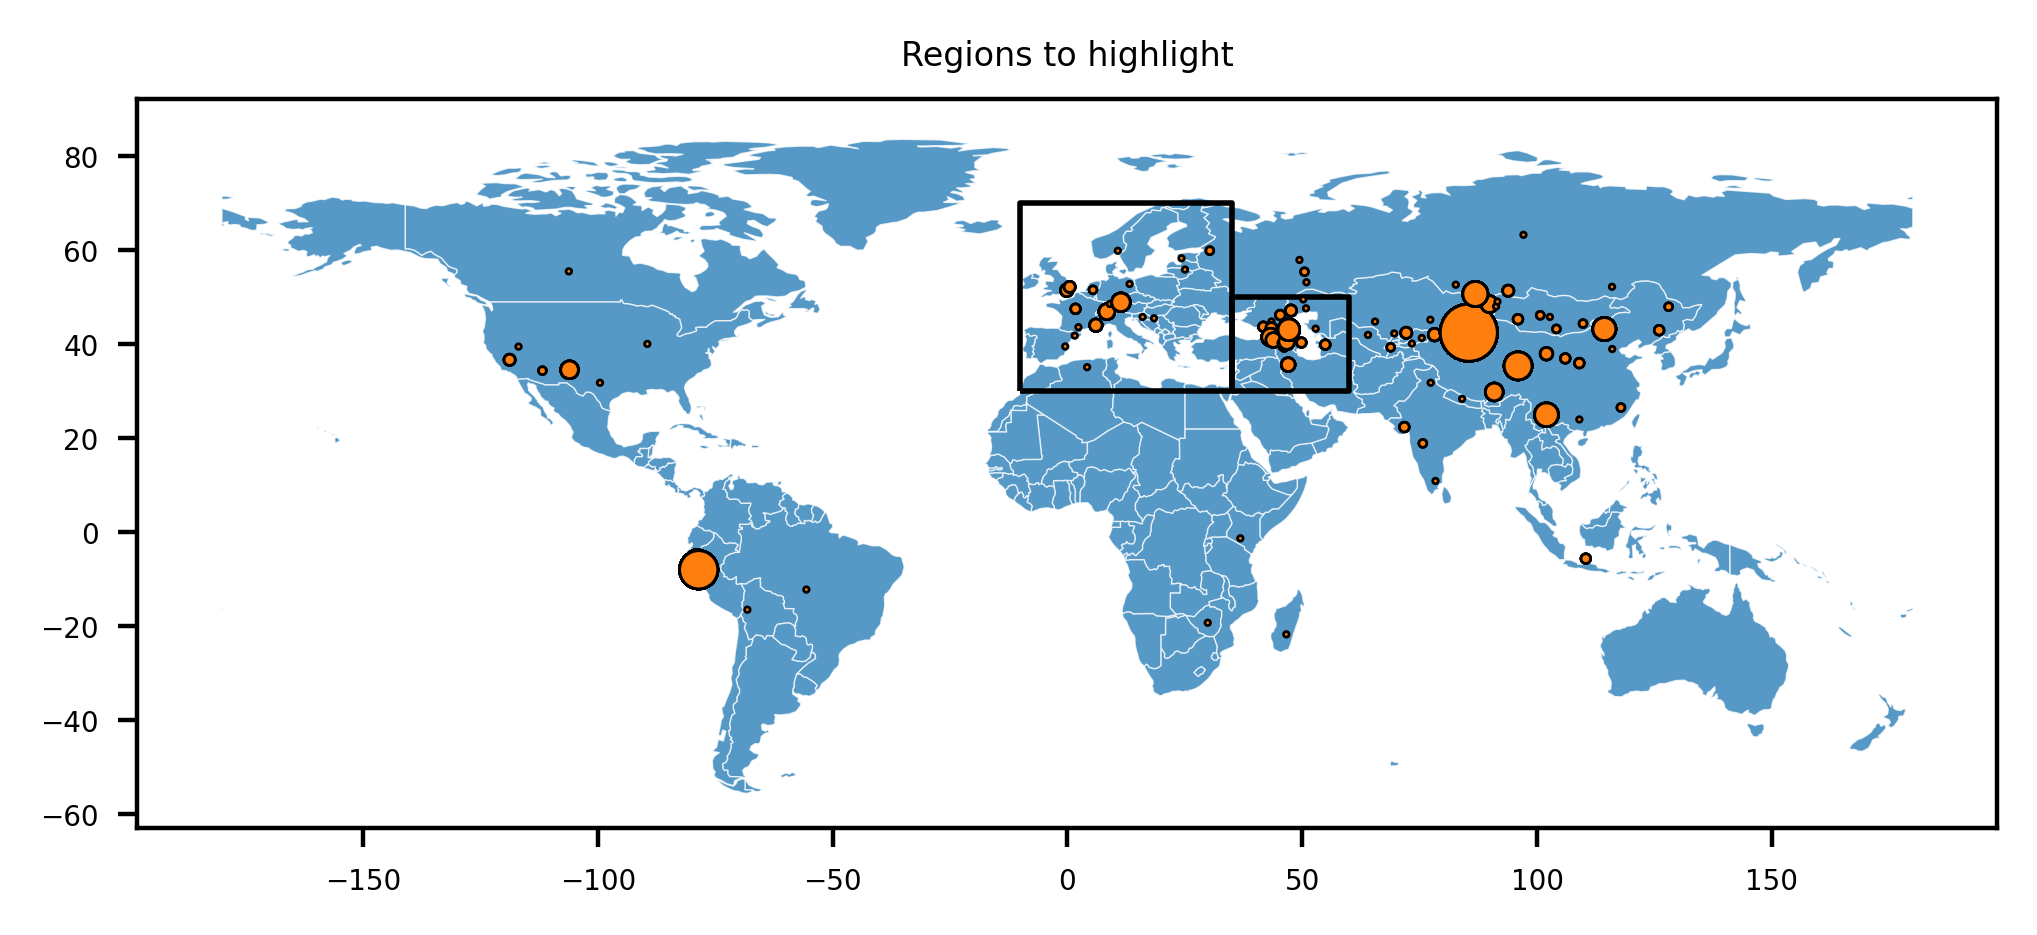

In [62]:
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax1 = plt.subplots(1, dpi=dpi)

world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.75, 
                    color=DEF_COL_LIST[0],
                    edgecolor="white", 
                    linewidth=0.25)
gdf_points.plot(ax=ax1, 
                zorder=2, 
                markersize=gdf_points_size, 
                color=DEF_COL_LIST[1],
                edgecolor="black",
                linewidths=0.5,
                )

caucasus_geoseries.plot(color="none", edgecolor="black", ax=ax1)
europe_geoseries.plot(color="none", edgecolor="black", ax=ax1)
ax1.set_ylim(-63,)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_title("Regions to highlight")